# Stellar Velocity

In [1]:
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
from scipy.stats import binned_statistic
from binned_stats import get_binned_statistic
import yaml

In [2]:
from auriga.snapshot import Snapshot
from auriga.images import figure_setup, set_axs_configuration
from auriga.paths import Paths
from auriga.parser import parse
from auriga.settings import Settings

In [15]:
figure_setup()
settings = Settings()

In [4]:
MIN_PART_COUNT = 100
RXY_RANGE = (0, 30)
N_BINS = 30

In [5]:
CONFIG_FILE = "02"
config = yaml.safe_load(open(f"../configs/{CONFIG_FILE}.yml"))
DISC_STD_CIRC = config["DISC_STD_CIRC"]
DISC_MIN_CIRC = config["DISC_MIN_CIRC"]
COLD_DISC_DELTA_CIRC = config["COLD_DISC_DELTA_CIRC"]
BULGE_MAX_SPECIFIC_ENERGY = config["BULGE_MAX_SPECIFIC_ENERGY"]
SUFFIX = config["FILE_SUFFIX"]

In [6]:
SAMPLE = [f"au{i}_or_l4_s127" for i in settings.groups["Included"]]

In [7]:
def read_data_vels(simulation: str) -> tuple:
    """
    This method returns the region tag, velocities and radius of the disc plane
    of the stars in the main object of the simulation.

    Parameters
    ----------
    simulation : str
        The simulation to consider.

    Returns
    -------
    tuple
        The properties.
    """
    settings = Settings()

    s = Snapshot(simulation=simulation, loadonlytype=[0, 1, 2, 3, 4, 5])
    s.add_circularity()
    s.add_reference_to_potential()
    s.add_normalized_potential()
    s.tag_particles_by_region(
        disc_std_circ=DISC_STD_CIRC,
        disc_min_circ=DISC_MIN_CIRC,
        cold_disc_delta_circ=COLD_DISC_DELTA_CIRC,
        bulge_max_specific_energy=BULGE_MAX_SPECIFIC_ENERGY)

    is_real_star = (s.type == 4) & (s.stellar_formation_time > 0)
    is_main_obj = (s.halo == s.halo_idx) & (s.subhalo == s.subhalo_idx)

    v_z_signed = s.vel[:, 2] * np.sign(s.pos[:, 2])

    return (s.region_tag[is_real_star & is_main_obj],
            s.rho[is_real_star & is_main_obj],
            s.v_rho[is_real_star & is_main_obj],
            s.v_phi[is_real_star & is_main_obj],
            v_z_signed[is_real_star & is_main_obj],
            np.linalg.norm(s.vel, axis=1)[is_real_star & is_main_obj],)

In [8]:
def create_binned_dataframe(simulations: list, rxy_range: tuple,
                            n_bins: int) -> pd.DataFrame:
    settings = Settings()
    feats = []
    feat_names = []
    for simulation in simulations:
        region_tag, rho, v_rho, v_phi, vz, vel = read_data_vels(simulation)
        for component, tag in settings.component_tags.items():
            is_region = (region_tag == tag)

            v_rho_bind, bin_edges, _ = binned_statistic(x=rho[is_region],
                values=v_rho[is_region], bins=n_bins, range=rxy_range)

            v_z_bind, _, _ = binned_statistic(x=rho[is_region],
                values=vz[is_region], bins=n_bins, range=rxy_range)

            v_phi_bind, _, _ = binned_statistic(x=rho[is_region],
                values=v_phi[is_region], bins=n_bins, range=rxy_range)

            v_std_bind, _, _ = binned_statistic(x=rho[is_region],
                values=vel[is_region], statistic="std",
                bins=n_bins, range=rxy_range)
            
            particle_count = binned_statistic(
                x=rho[is_region],
                values=np.ones_like(rho[is_region]), statistic="count",
                bins=n_bins, range=rxy_range)[0]

            feats.append(v_rho_bind)
            feat_names.append(
                f"{simulation.upper()}_RadialVelocity_{component}_km/s")

            feats.append(v_z_bind)
            feat_names.append(
                f"{simulation.upper()}_VerticalVelocity_{component}_km/s")

            feats.append(v_phi_bind)
            feat_names.append(
                f"{simulation.upper()}_TangentialVelocity_{component}_km/s")

            feats.append(v_std_bind)
            feat_names.append(
                f"{simulation.upper()}_VelocityDispersion_{component}_km/s")
            
            feats.append(particle_count)
            feat_names.append(
                f"{simulation.upper()}_ParticleCount_{component}")

    feats.append(bin_edges[1:] - np.diff(bin_edges)[0] / 2)
    feat_names.append("BinCenters_ckpc")

    df = pd.DataFrame(np.array(feats).T, columns=feat_names)

    return df

In [9]:
# Create DataFrame with data for all galaxies
data = create_binned_dataframe(
    simulations=SAMPLE, rxy_range=RXY_RANGE, n_bins=N_BINS)

In [10]:
colors = ["green", "red", "blue", 'k']
labels = ["$v_r$", r"$v^\dagger_z$", "$v_\phi$", "$\sigma_v$"]
features = ["RadialVelocity", "VerticalVelocity",
            "TangentialVelocity", "VelocityDispersion"]

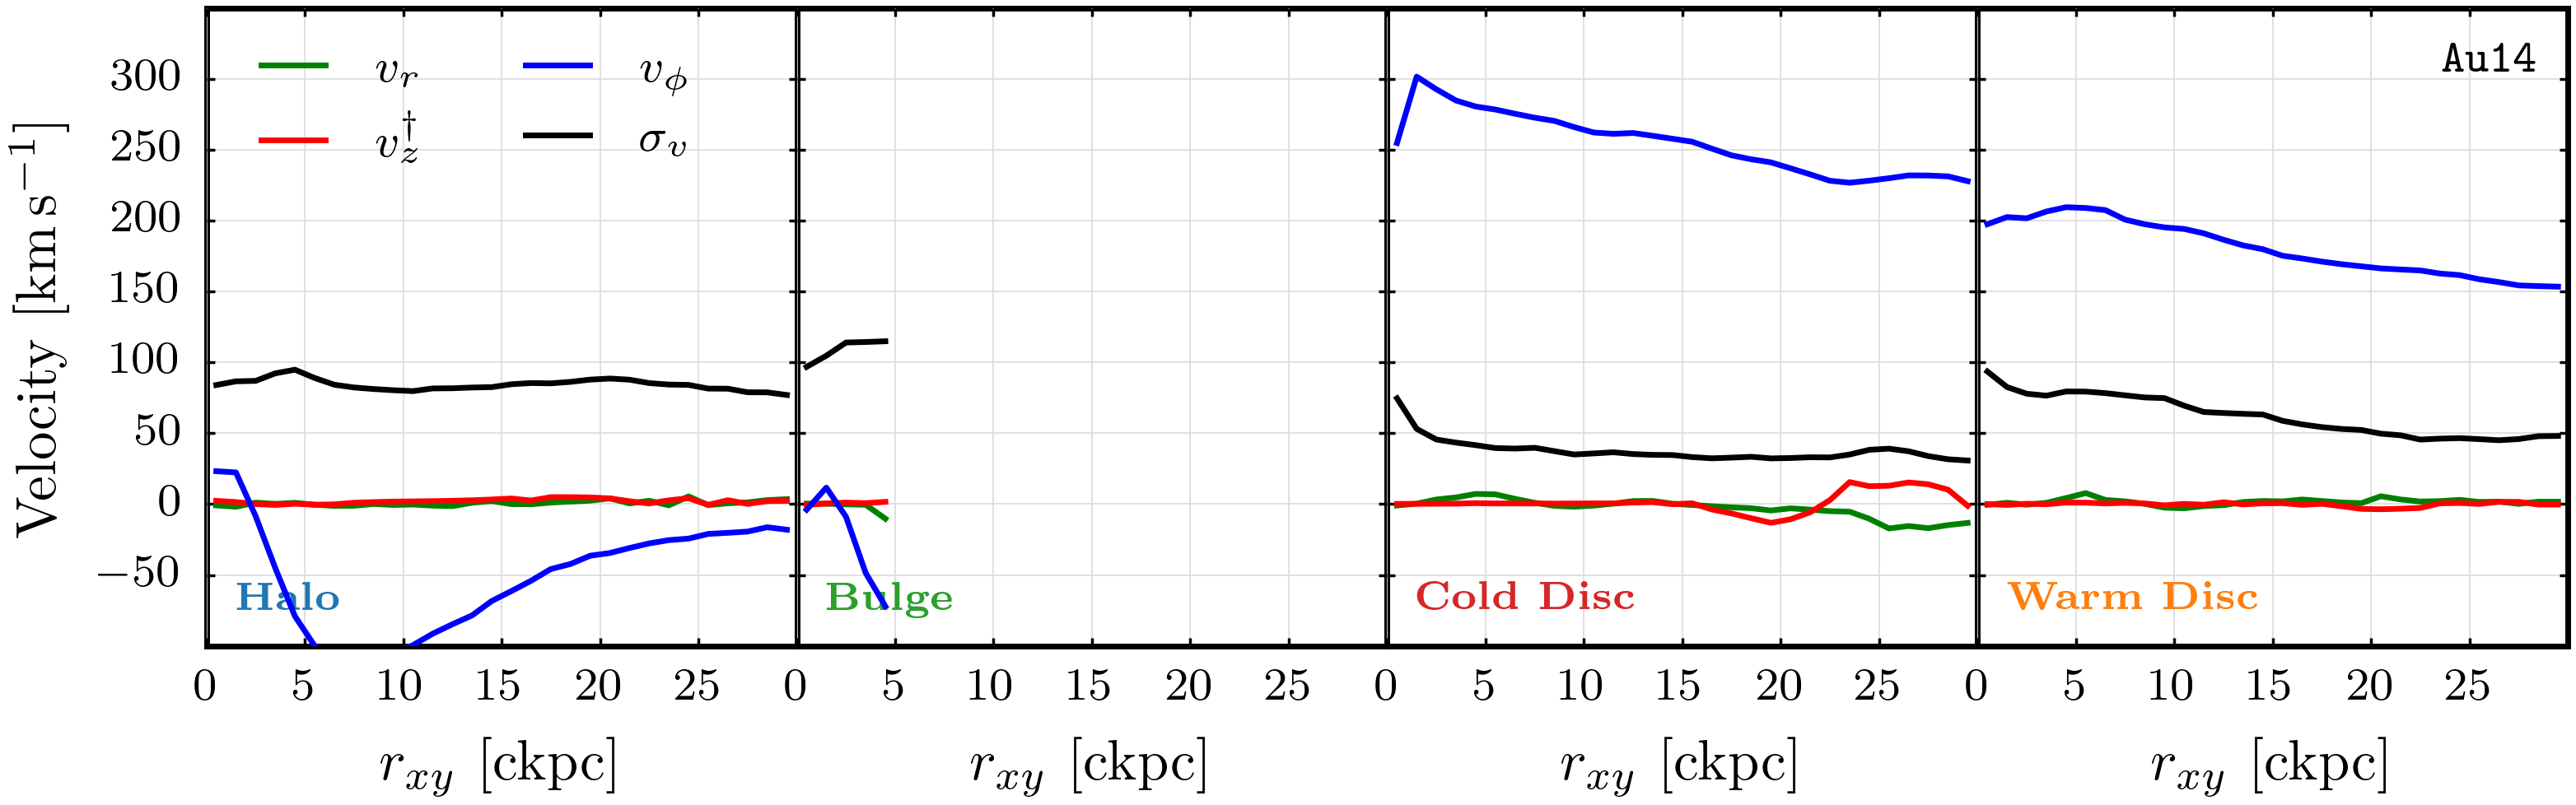

In [33]:
for simulation in ["au14_or_l4_s127"]:

    fig = plt.figure(figsize=(7.4, 2.0))
    gs = fig.add_gridspec(nrows=1, ncols=4, hspace=0.0, wspace=0.0)
    axs = gs.subplots(sharex=True, sharey=True)

    for ax in axs.flat:
        ax.grid(False)
        ax.tick_params(which='both', direction="in")
        ax.set_xlim(0, 30)
        ax.set_ylim(-100, 350)
        ax.set_xticks([0, 5, 10, 15, 20, 25])
        ax.set_yticks([-50, 0, 50, 100, 150, 200, 250, 300])
        ax.set_xlabel(r'$r_{xy}$ [ckpc]')
        ax.set_ylabel(r'Velocity [$\mathrm{km} \, \mathrm{s}^{-1}]$')
        ax.label_outer()
        ax.grid(True, ls='-', lw=0.25, c="gainsboro")

    for component, idx in settings.component_tags.items():
        for i, feature in enumerate(features):
            is_finite = np.isfinite(
                data[f"{simulation.upper()}_{feature}_{component}_km/s"])
            has_particles = data[
                f"{simulation.upper()}_ParticleCount_{component}"] \
                    >= MIN_PART_COUNT

            axs[idx].plot(
                data["BinCenters_ckpc"][is_finite & has_particles],
                data[f"{simulation.upper()}_{feature}_{component}_km/s"][
                    is_finite & has_particles],
                lw=1.0, label=labels[i], zorder=10, c=colors[i])

        axs[idx].text(
            x=1.5, y=-80, size=7.0, ha='left', va='bottom',
            color=settings.component_colors[settings.components[idx]],
            s=r"$\textbf{" \
                + settings.component_labels[settings.components[idx]] \
                + r"}$")

    axs[0].legend(loc="upper left", framealpha=0, fontsize=8.0, ncol=2)

    galaxy, _, _, _ = parse(simulation)
    label = f"Au{galaxy}"
    axs[3].text(x=0.95, y=0.95, s=r"$\texttt{" + label + "}$",
                size=8.0, ha="right", va="top", transform=axs[3].transAxes)

    plt.show()
    # fig.savefig(
    #     f"../images/stellar_velocities_by_region/{simulation}{SUFFIX}.pdf")
    # plt.close(fig)

## Average

In [63]:
# Remove zeros in standard deviation
for simulation in SAMPLE:
    for component, idx in settings.component_tags.items():
        data[f"{simulation.upper()}_VelocityDispersion_{component}_km/s"][
            data[f"{simulation.upper()}_VelocityDispersion_{component}_km/s"] \
                < 0.1] = np.nan

In [64]:
labels = ["$v_\phi$", "$v_r$", r"$v^\dagger_z$", "$\sigma_v$"]
features = ["TangentialVelocity", "RadialVelocity", "VerticalVelocity",
            "VelocityDispersion"]

In [72]:
fig = plt.figure(figsize=(7.4, 8.0))
gs = fig.add_gridspec(nrows=6, ncols=4, height_ratios=[1, 0.05, 1, 1, 0.05, 1],
                      hspace=0.0, wspace=0.0)
axs = gs.subplots(sharex=True, sharey=False)


for ax in axs.flat:
    ax.grid(False)
    ax.tick_params(which='both', direction="in")
    ax.set_xlim(0, 30)
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    ax.set_xlabel(r'$r_{xy}$ [ckpc]')
    ax.label_outer()
    ax.grid(True, ls='-', lw=0.25, c="gainsboro")

for i in range(axs.shape[1]):
    axs[0, i].set_ylim(-100, 350)
    axs[0, i].set_yticks([-50, 0, 50, 100, 150, 200, 250, 300])

    for j in ([2, 3]):
        axs[j, i].set_ylim(-50, 150)
        axs[j, i].set_yticks([0, 50, 100])
    
    axs[5, i].set_ylim(0, 150)
    axs[5, i].set_yticks([50, 100])

axs[0, 0].set_ylabel(r'$v_\phi$ [$\mathrm{km} \, \mathrm{s}^{-1}]$')
axs[2, 0].set_ylabel(r'$v_r$ [$\mathrm{km} \, \mathrm{s}^{-1}]$')
axs[3, 0].set_ylabel(r'$v_z^\dagger$ [$\mathrm{km} \, \mathrm{s}^{-1}]$')
axs[5, 0].set_ylabel(r'$\sigma_v$ [$\mathrm{km} \, \mathrm{s}^{-1}]$')

for ax in axs[1, :]:
    ax.set_visible(False)

for ax in axs[4, :]:
    ax.set_visible(False)

for simulation in SAMPLE:
    c, label, zorder, lw = "silver", None, 10, 0.75
    # if simulation == "au11_or_l4_s127":
    #     c, label, zorder = "tab:purple", r"$\texttt{AU11_OR_L4_S127}$", 11
    #     lw = 1.25
    if simulation == "au6_or_l4_s127":
        c, label, zorder = "black", r"$\texttt{Au6}$", 12
        lw = 1.25
    for component, idx in settings.component_tags.items():
        for i, feature in enumerate(features):
            is_finite = np.isfinite(
                data[f"{simulation.upper()}_{feature}_{component}_km/s"])
            has_particles = data[
                f"{simulation.upper()}_ParticleCount_{component}"] \
                    >= MIN_PART_COUNT

            row_idx = i
            if i >= 1:
                row_idx = i + 1
            if i == 3:
                row_idx += 1

            axs[row_idx, idx].plot(
                data["BinCenters_ckpc"][is_finite & has_particles],
                data[f"{simulation.upper()}_{feature}_{component}_km/s"][
                    is_finite & has_particles],
                lw=lw, zorder=zorder, c=c, label=label)

for component, j in settings.component_tags.items():
    axs[0, j].text(
        x=0.5, y=0.95, size=9.0, ha="center", va="top",
        transform=axs[0, j].transAxes,
        color=settings.component_colors[settings.components[j]],
        s=r"$\textbf{" \
            + settings.component_labels[settings.components[j]] \
            + r"}$")
    # for i, feature in enumerate(features):
    #     axs[i, j].plot(
    #         data["BinCenters_ckpc"],
    #         np.nanmean(
    #             data[[f"{simulation.upper()}_{feature}_{component}_km/s" \
    #                 for simulation in SAMPLE]], axis=1),
    #         lw=1.25, zorder=15, c='k', label="Average")

axs[2, 0].legend(loc="upper left", framealpha=0, fontsize=8.0)

fig.savefig(
    f"../images/stellar_velocities_by_region/included_average{SUFFIX}.pdf")
plt.close(fig)